# Baseline 셋팅

In [251]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [252]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### 1) 데이터 준비 및 불러오기

In [253]:
#데이터 준비
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [254]:
#데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


# 데이터 살펴보기
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 타겟 변수인 집의 가격
- bedrooms : 침실의 수
- bathrooms : 침실당 화장실 개수
- sqft_living : 주거 공간의 평방 피트
- sqft_lot : 부지의 평방 피트
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트
- sqft_basement : 지하실의 평방 피트
- yr_built : 집을 지은 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [255]:
#라벨제거 
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## price와의 상관관계

In [256]:
data.corr(method='pearson')

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,-0.101618,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
bedrooms,0.010520,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.101618,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873
grade,0.078622,0.375286,0.666278,0.762543,0.119906,0.462598,0.088061,0.247924,-0.143599,1.000000,0.759240,0.162657,0.440608,0.030155,-0.186541,0.112319,0.202130,0.715321,0.119734


<AxesSubplot:>

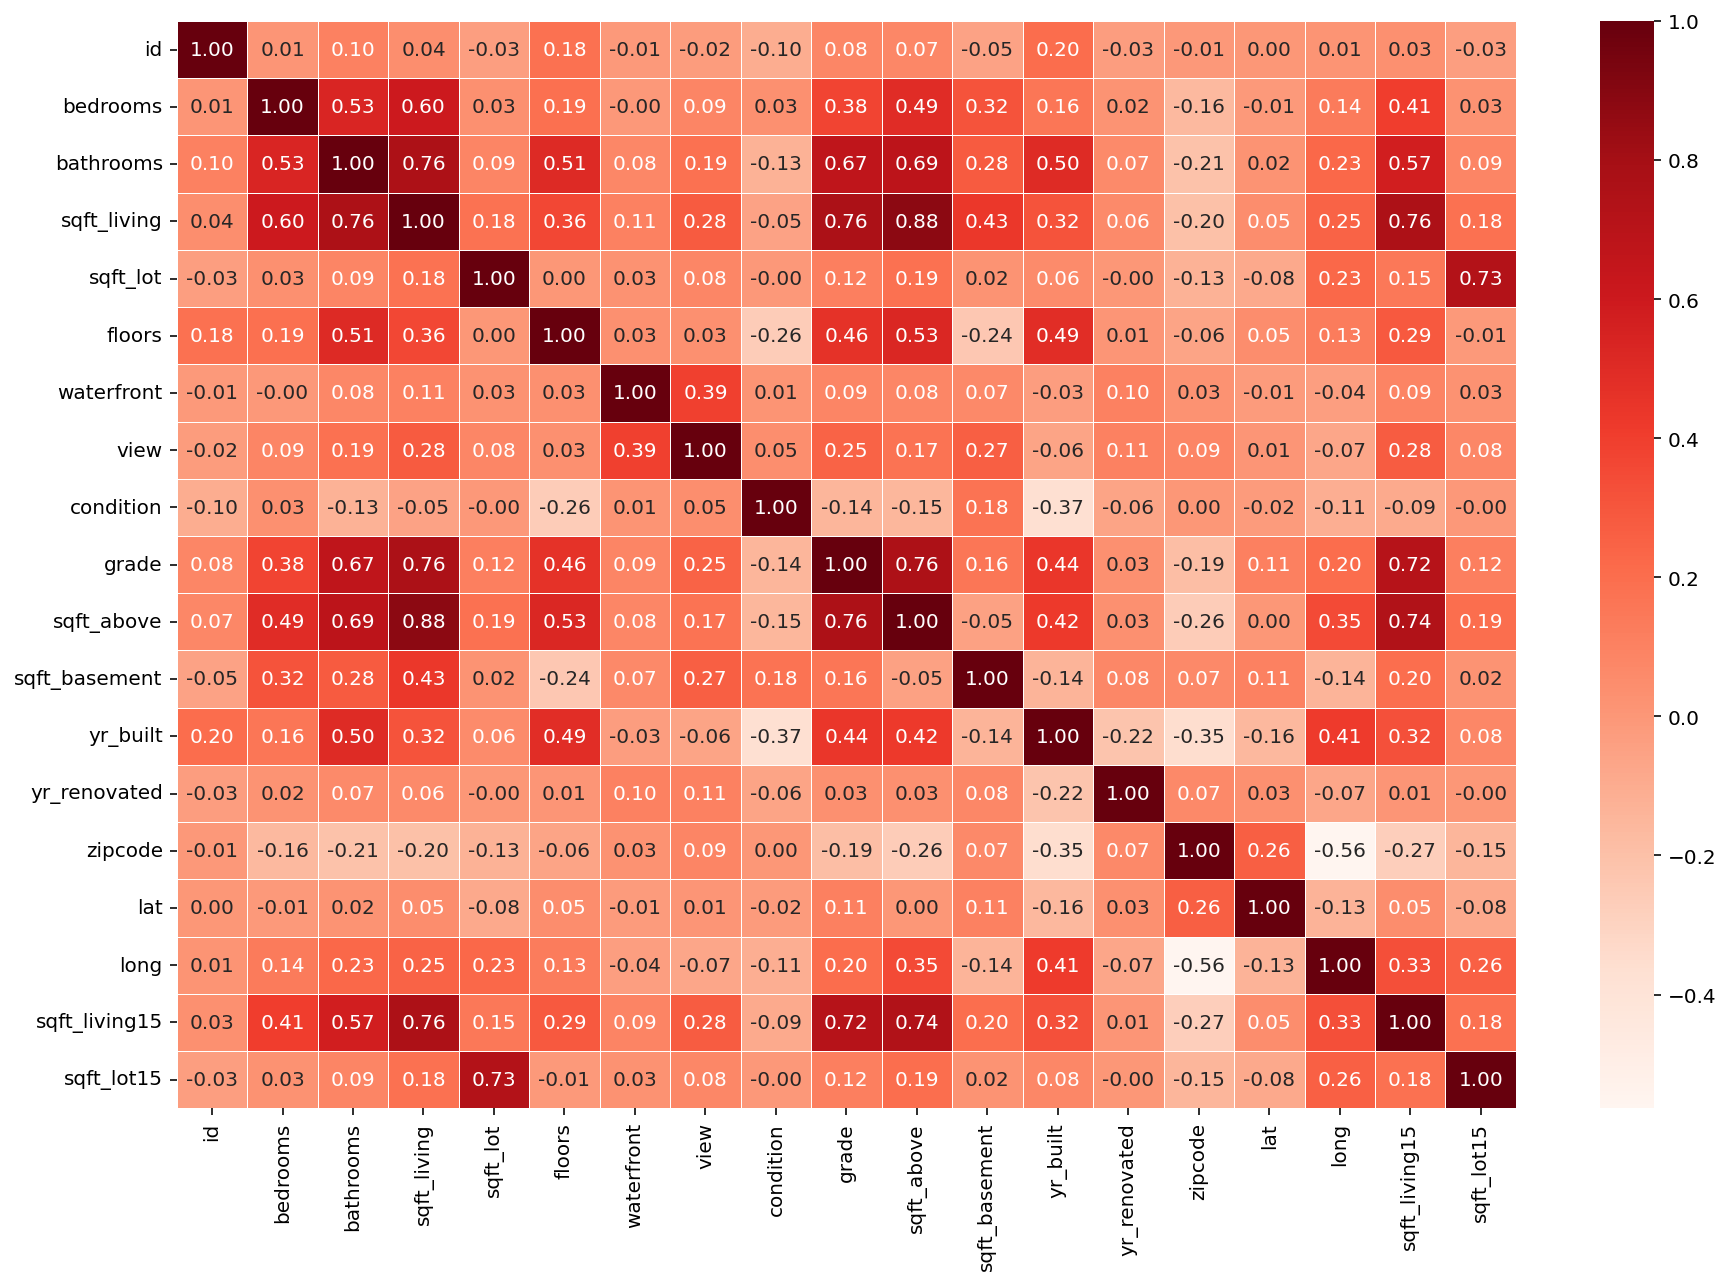

In [257]:
plt.figure(figsize = (15,10))
sns.heatmap(data.corr(), annot=True, cmap='Reds',fmt='.2f',linewidths=.5)

위의 히트맵을 확인하면 0.88로 sqft_above(지하실을 제외한 평방 피트) 와 sqft_living(주거 공간의 평방 피트)의 상관관계가 가장 높다는 것을 알 수 있다. 지하실을 제외한 평당 피트가 주거공간과 같은 개념이라 생각되어진다.

In [258]:
# 학습 데이터와 테스트 데이터 합치기
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


### 전처리

<AxesSubplot:>

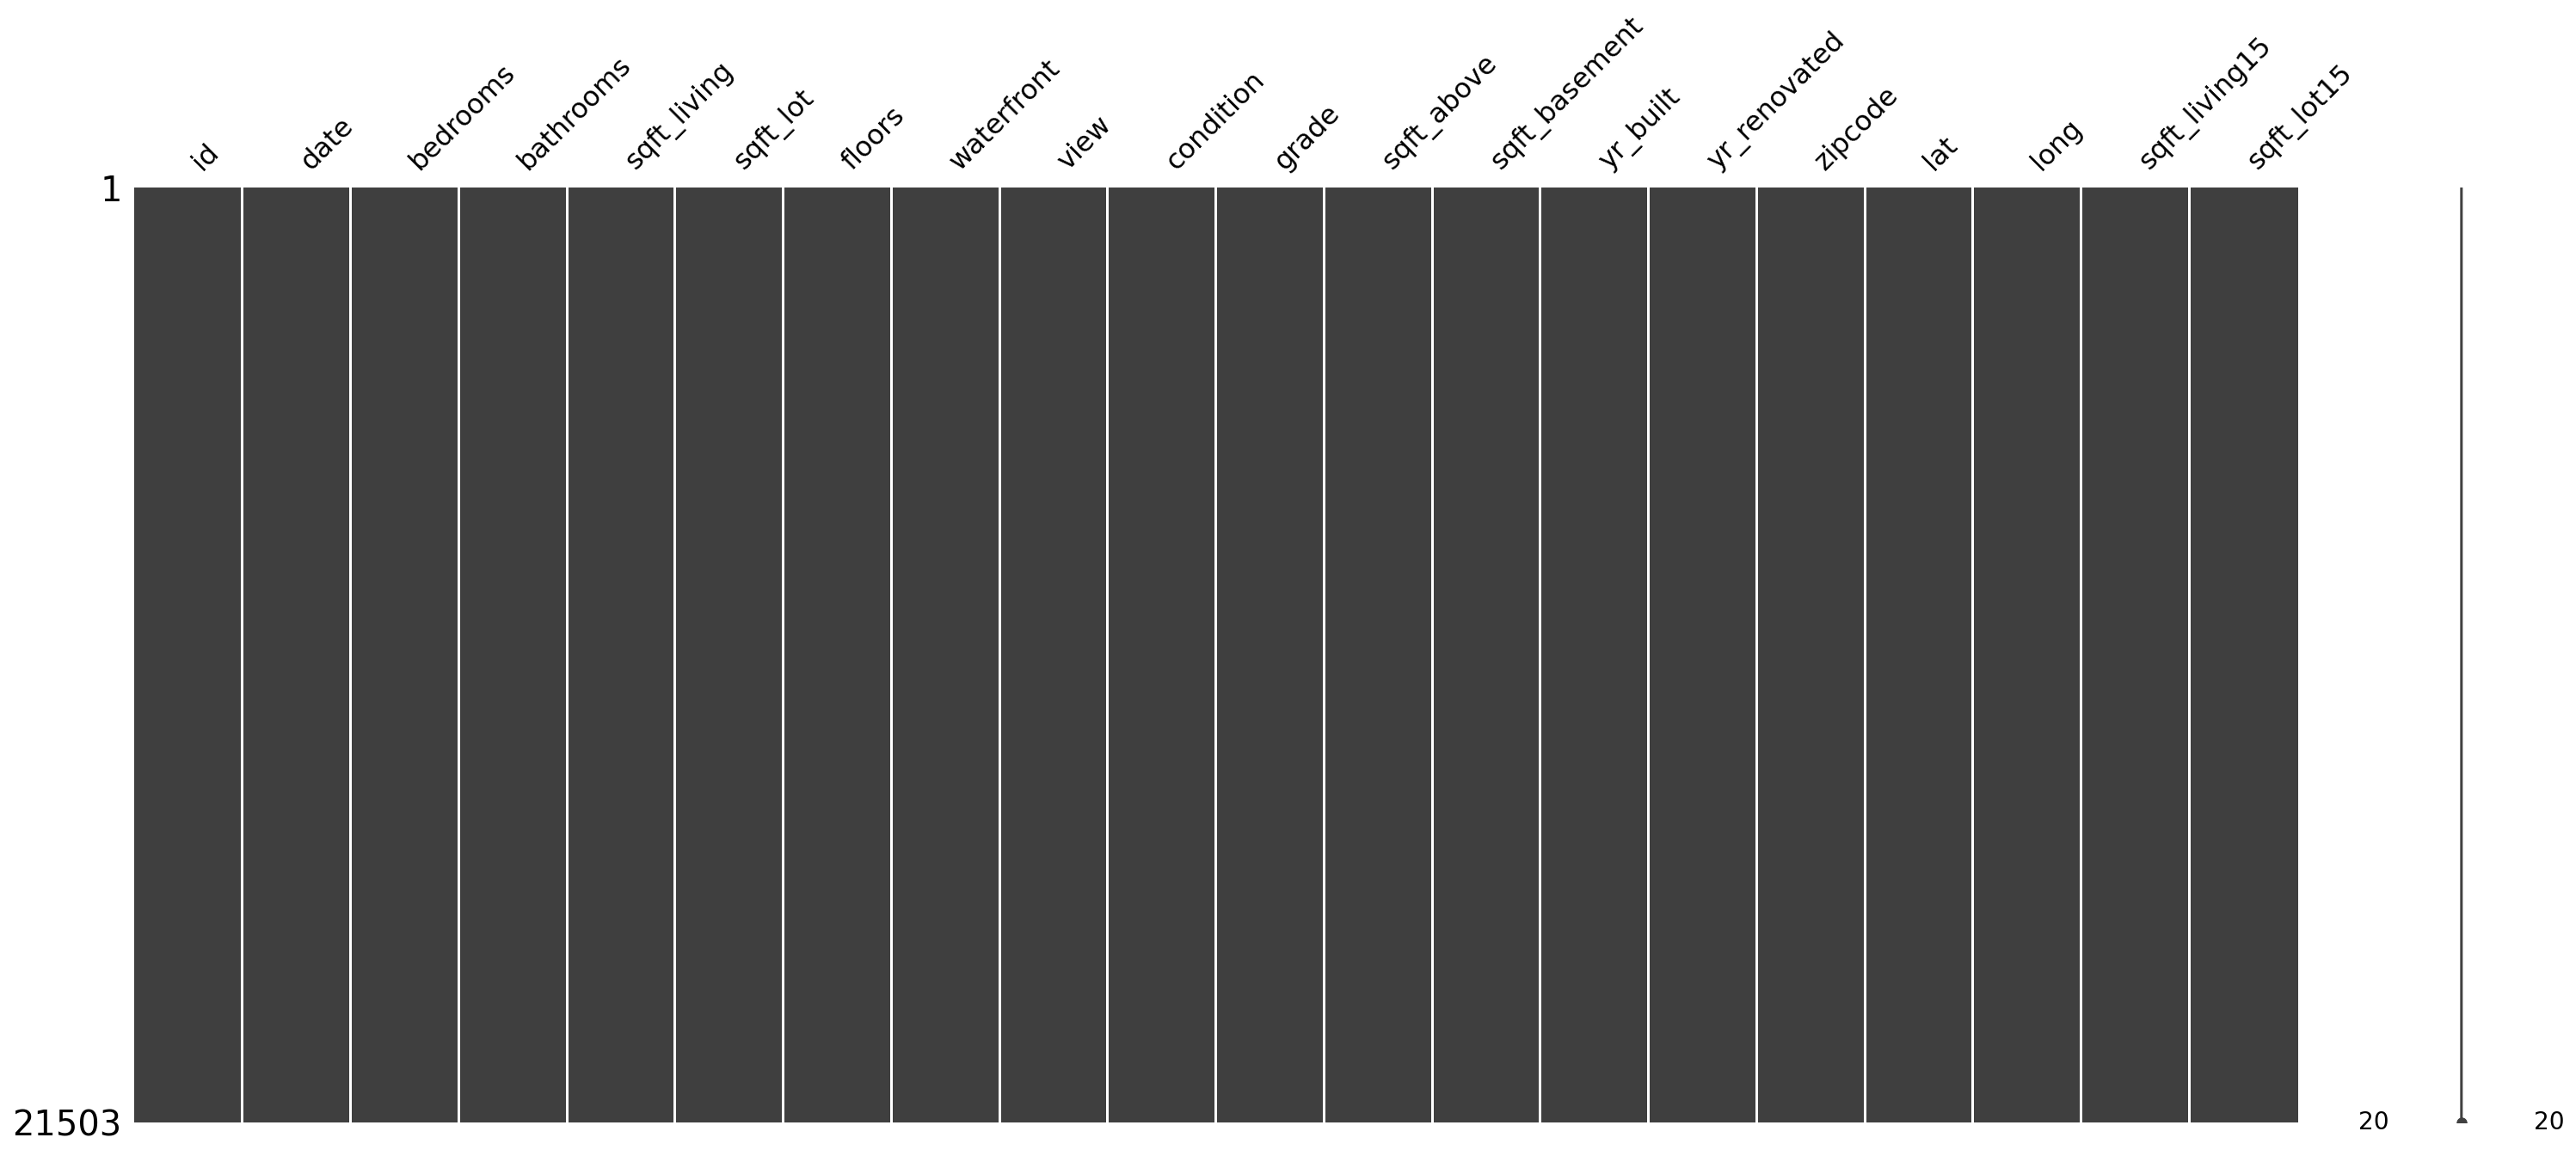

In [259]:
#간단한 전처리
msno.matrix(data)

### 2) 결측치 확인

In [260]:
#결측치 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 3) 변수정리

In [261]:
# id, date 변수정리
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [262]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [263]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

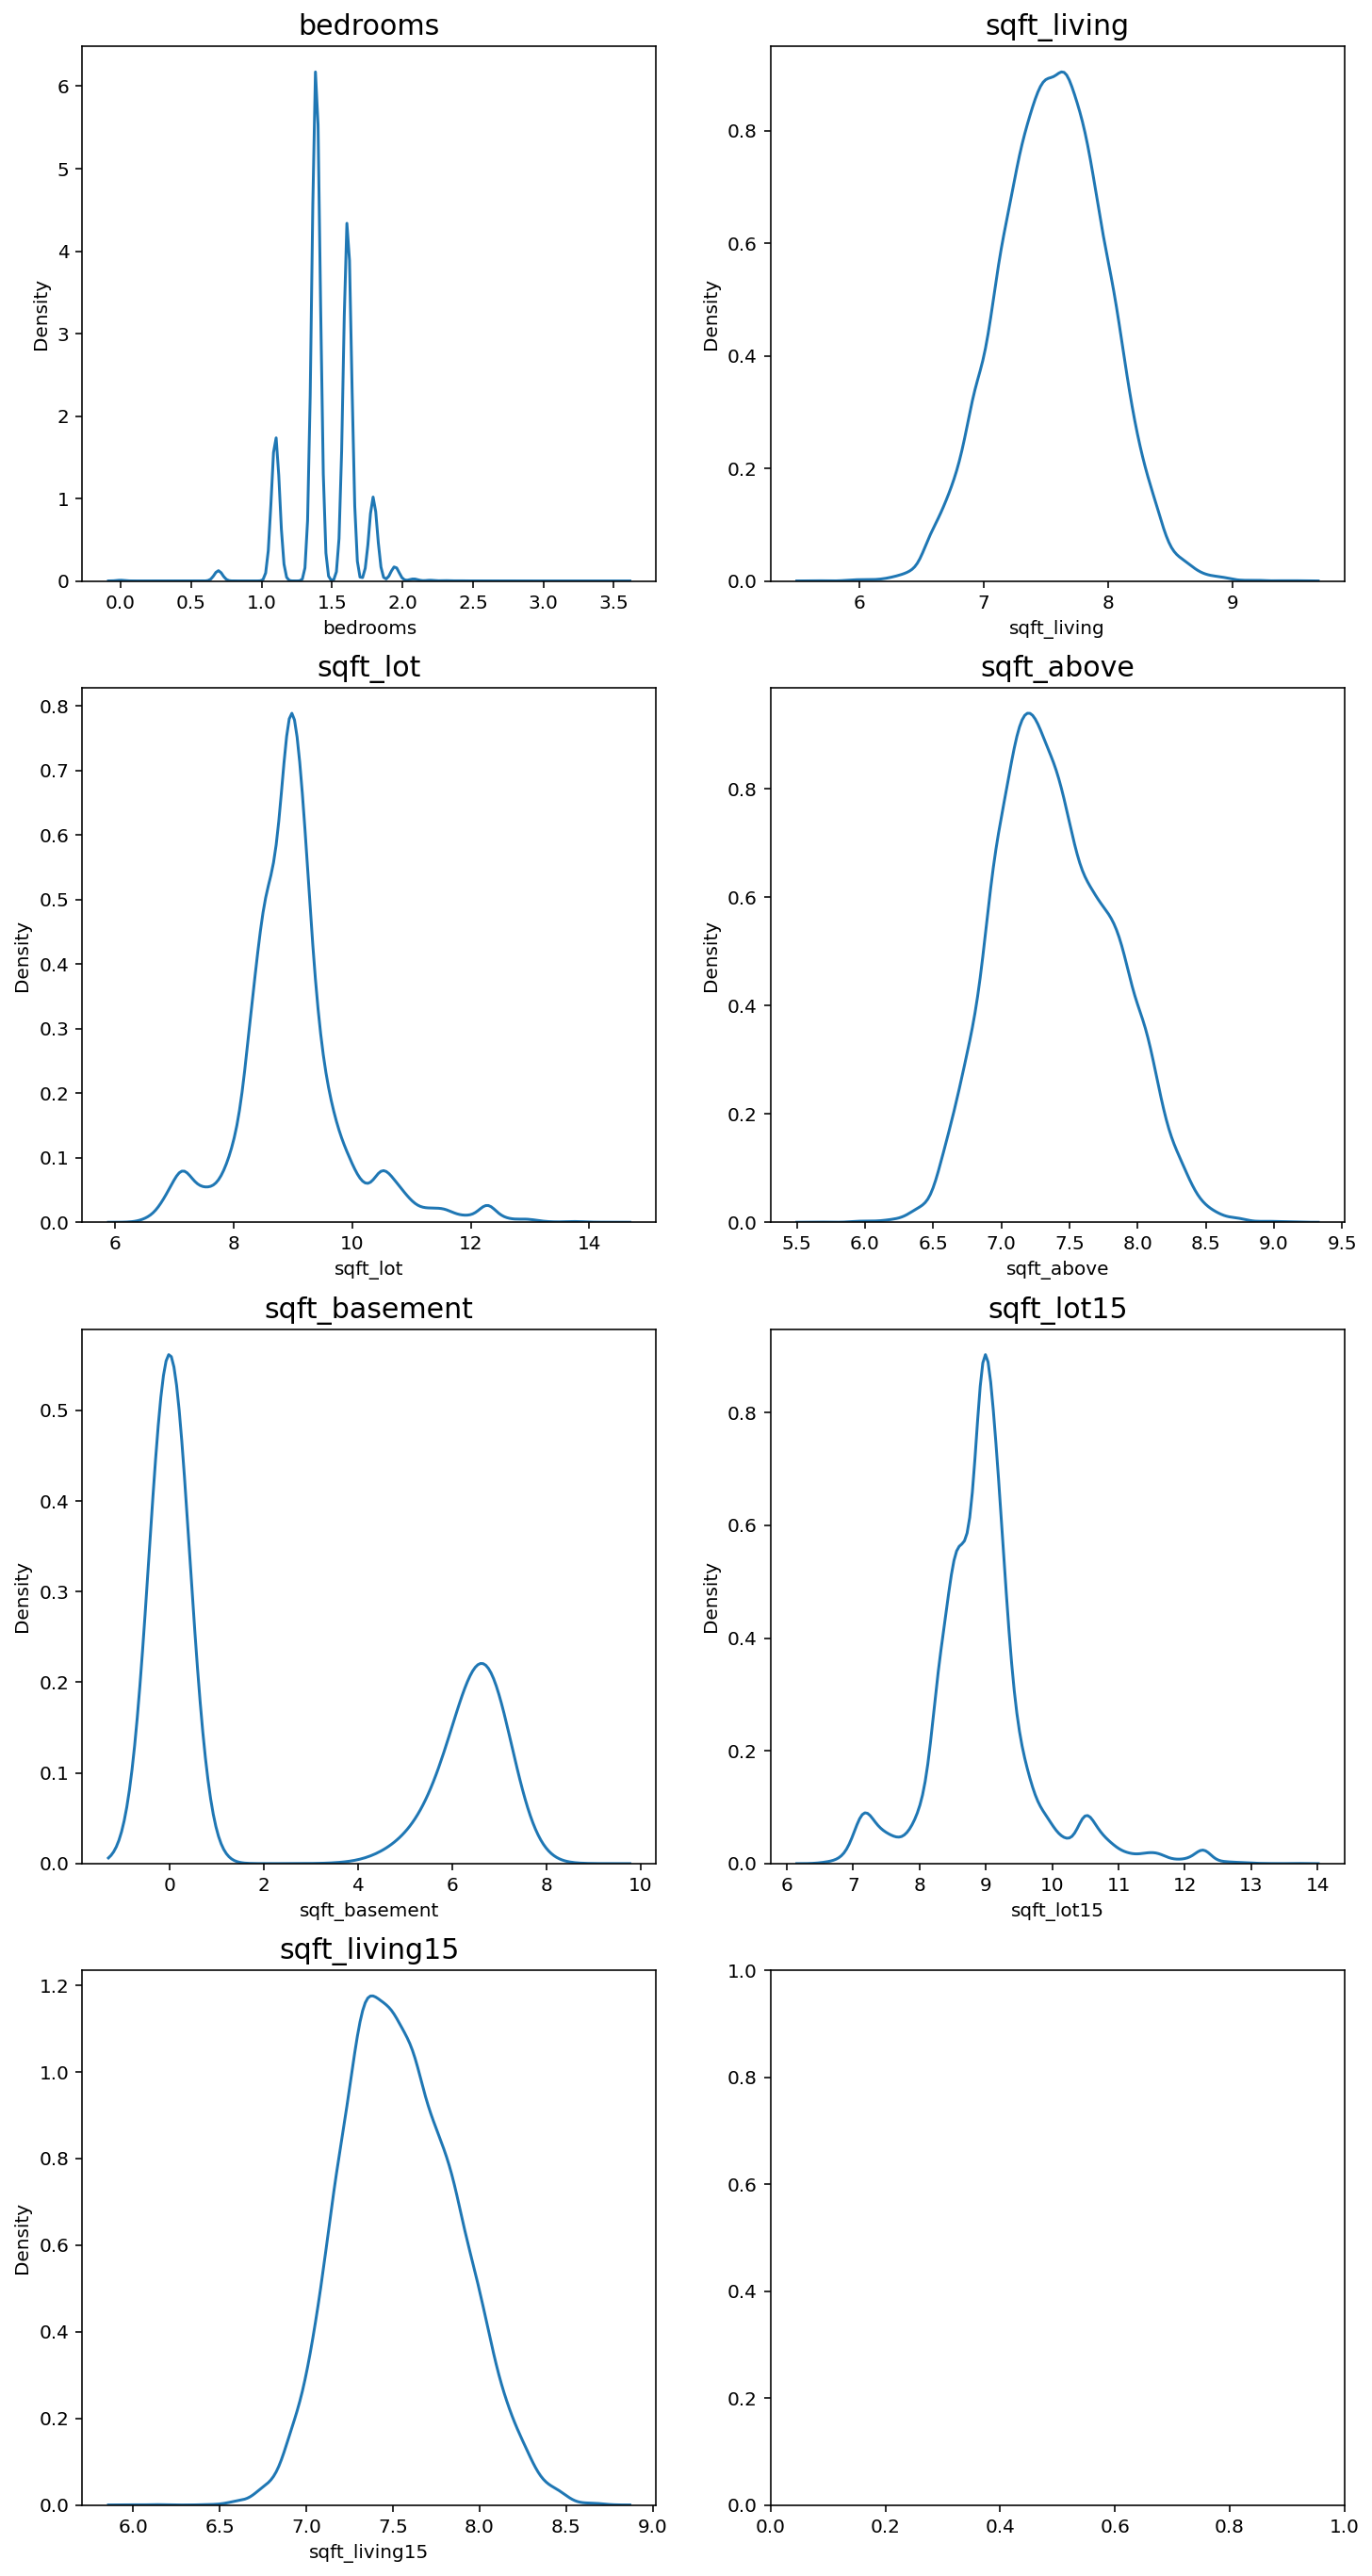

In [264]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [265]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


# Average Blending의 gboost, xgboost, lightgbm 모델

In [266]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [267]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [268]:
# Cross Validation
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [269]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


위 수치는 모델의 성능을 간단히 평가하여 나온 값이다. 대체적으로 0.8점대를 가지고 있어 훈련데이터로서 괜찮은 성능을 보인다.

# 블렌딩(Blending)

In [270]:
# Make Submission File
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [271]:
#함수를 이용해 예측
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

위의 수치는 AveragingBlending을 이용하여 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환한 것이다.

In [272]:
#파일 저장 전 id, price로 이루어진 데이터 프레임 만들기
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [273]:
#submission 파일 저정
my_submission_path = join(data_dir, 'sample_submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/sample_submission.csv


# 최적의 모델을 찾아서

In [274]:
#데이터 다시 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [275]:
#train전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [276]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [277]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [278]:
#test전처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


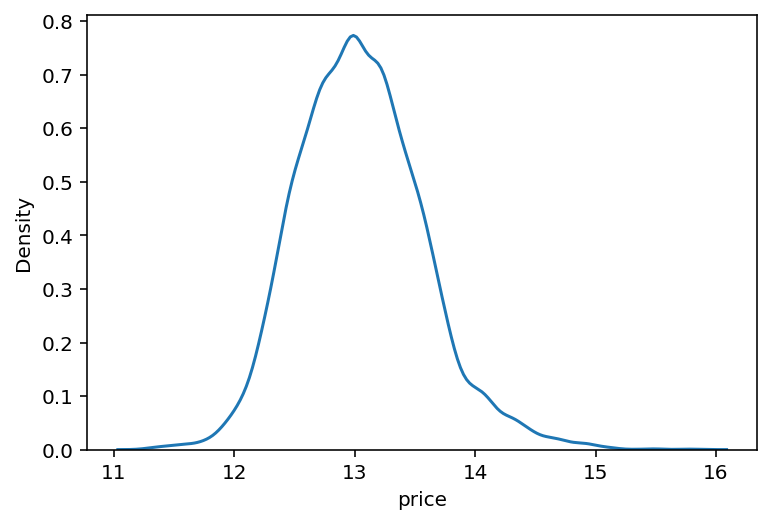

In [279]:
#가격 데이터의 분포도, log1p를 이용하여
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

### RMSE계산

In [280]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [281]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [282]:
# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 모델가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [283]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택  
random_state=2020        # 고정값 세팅 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

앞으로 베이스라인에서부터 시작해서 다양한 실험을 통해 성능이 개선되는지를 검증해 보려고 한다. 이때, 어떤 시도가 모델 성능 향상에 긍정적이었는지 여부를 판단하기 위해서는 랜덤적 요소의 변화 때문에 생기는 불확실성을 제거해야 한다.

In [284]:
# 각 모델 별로 학습 및 예측
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

for문을 이용하여 각 모델의 학습과 RMSE값을 얻을 수 있다.

# 그리드 탐색

In [285]:
from sklearn.model_selection import GridSearchCV
# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비
param_grid = {
    'n_estimators': [50, 400],
    'max_depth': [1, 50],
}
#모델은 LGBM 사용
model = LGBMRegressor(random_state=random_state)

- model, param_grid와 함께 다른 여러 가지 인자를 넣어서 GridSearchCV를 수행할 수 있다.
1. GridSearchCV를 이용해서 grid_model 모델을 초기화
2. train과 y 데이터로 모델을 간단히 학습
3. 그 후 param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료

In [286]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 50], 'n_estimators': [50, 400]},
             scoring='neg_mean_squared_error', verbose=1)

#### 'totalling 20 fits'?
- cross validation을 5번 진행하는 이유는, 각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문이다.
- param_grid에 n_estimators 두 가지, max_depth 두 가지를 넣었으므로 가능한 조합은 총 2 × 2 = 4가지 , cross validation은 각 경우마다 5번을 진행하니 총 20 fits를 진행한다.

In [287]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']
print(params)
print(score)

[{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 400}, {'max_depth': 50, 'n_estimators': 50}, {'max_depth': 50, 'n_estimators': 400}]
[-0.07339447 -0.0402151  -0.02919842 -0.02620615]


params에는 각 파라미터의 조합이, score에는 각 조합에 대한 점수가 들어가 있다.

In [288]:
#데이터 프레임
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,400,-0.040215
2,50,50,-0.029198
3,50,400,-0.026206


#### 왜 점수가 음수?
GridSearchCV 에서 모델을 초기화할 때 scoring 인자에 MSE에 음수를 취한 값인 neg_mean_squared_error를 입력했다.
-> Regression 문제를 풀고 있기 때문에 그에 알맞은 성능 평가 지표인 
neg_mean_squared_error를 사용했기 때문에 점수가 음수로 표현되는 것이다.

In [289]:
#RMSE 점수
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,400,-0.040215,0.200537
2,50,50,-0.029198,0.170875
3,50,400,-0.026206,0.161883


- 위 표의 값은 정확히 말하면 RMSE가 아니라 RMSLE를 구한 것이다
- 즉 Root Mean Squared Log Error : log를 취한 값에서 RMSE를 구했다는 뜻

In [290]:
#컬럼의 이름을 RMSLE로 변환
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,400,-0.040215,0.200537
2,50,50,-0.029198,0.170875
3,50,400,-0.026206,0.161883


In [291]:
#sort_values를 이용해 RMSLE값 오름차순 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,50,400,-0.026206,0.161883
2,50,50,-0.029198,0.170875
1,1,400,-0.040215,0.200537
0,1,50,-0.073394,0.270914


In [292]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [293]:
#간단한 그리드 탐색
param_grid = {
    'n_estimators': [50, 400],
    'max_depth': [1, 50],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,50,400,-0.026206,0.161883
2,50,50,-0.029198,0.170875
1,1,400,-0.040215,0.200537
0,1,50,-0.073394,0.270914


In [294]:
# 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성
model = LGBMRegressor(max_depth=50, n_estimators=400, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.14998393, 13.10917043, 14.15445506, ..., 13.05624011,
       12.6663428 , 13.02200636])

In [295]:
 # np.expm1()로 원래값 되돌리기
prediction = np.expm1(prediction)
prediction

array([ 514001.77060649,  493445.85137639, 1403464.4557135 , ...,
        468006.73728179,  316899.39743998,  452256.21640271])

In [296]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [297]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


# 회고

(1)전체적인흐름  
제일 먼저 데이터의 전처리 과정을 통해 log1p를 이용하여 가격 데이터의 분포도를 알아보았다. 그 후 XGBRegressor, LGBMRegressor, GradientBoostingRegresso모델을 이용하여 cv score을 계산하였다. 그리드 모델을 이용해  AveragingBlending의 예측 결괏값을 모아서 평균한 값을 반환하였다. 또한 RandomForest을 포함하여 그리드 모델을 통해 RMSLE를 계산해보았다.

(2)추가 & 변경한 부분  
추가적으로는 각 colums 들의 상관관계를 나타내는 히트맵을 만들어 보았고 max_depth를 10에서 50으로 변경 시켜 보았다. 50에서 80으로 변경시켜봤지만 점수에는 영향을 미치지않았다. n_estimators의 수치를 100에서 200으로 그리고 400까지 늘려보니 더 나은 점수를 얻었다. n_estimators 파라미터는 반복 수행하는 트리의 개수를 의미하는데 반복하는 개수가 많아질 수록 탐색하기 좋은 조건이 될 것이라 생각된다.

(3)시도해본것  
스태킹을 시도하였으나 오류가 나는 부분들을 이해하지 못하고 어떤 부분을 고쳐서 사용해야하는지 판단이 서지 않았다. 많은 시도 끝에 스태킹은 성공하지 못한 채 마무리되었다.

(4)결과  
처음 제출한 submission파일은 575671.71462점이였고 가장 좋은 점수를 받은 submission파일은  107622.69464점 이다.  

